<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/transfer_learning_(ants_and_bees).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

0. Get a model trained on a large-scale dataset.
   (e.g. ILSVRC dataset)

1. Take feature extraction layers of the pretrained model (Remove the classification layer and take only feature extraction layers)

2. Add classification layer for the target task on top of the feature extraction layers.

3. Learn the new classification layer on the target dataset.




# Classification of ant and bee images

* Target dataset: ants and bees
  - Two classes { ant, bee }
  - train set: 123 ant images + 121 bee images 
  - validation set: 70 ant images + 83 bee imges

* Dataset for pre-trining: ILSVRC (ImageNet Large-Scale Visual Recognition Challenge)
  - 1000 object classes
  - 1.3M training samples, 50K validation samples, 100k test samples



출처 :
- (Original) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- (Korean) https://blog.naver.com/PostView.nhn?blogId=ckdgus1433&logNo=221407059199&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# download data from https://download.pytorch.org/tutorial/hymenoptera_data.zip
# Run the following code just once.
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

hymenoptera_data  hymenoptera_data.zip	sample_data


In [0]:
!ls hymenoptera_data

In [0]:
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## References

* torchvision.datasets.ImageFolder class: https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder


In [0]:
# transform for data augmentation (data augmentation improves generalization)

data_transforms = {
    # transform for training
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    # transform for test
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/gdrive/My Drive/Colab Notebooks/hymenoptera_data'
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = { 'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=4),
                'val' : torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                             shuffle=True, num_workers=4) }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("# of training samples: ", dataset_sizes['train'])
print("# of test samples: ", dataset_sizes['val'])

class_names = image_datasets['train'].classes
print("class_names = ", class_names)

# of training samples:  244
# of test samples:  153
class_names =  ['ants', 'bees']


In [0]:
dir(image_datasets['train'])

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_find_classes',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'imgs',
 'loader',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [0]:
image_datasets['train'].imgs

[('hymenoptera_data/train/ants/0013035.jpg', 0),
 ('hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', 0),
 ('hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', 0),
 ('hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', 0),
 ('hymenoptera_data/train/ants/116570827_e9c126745d.jpg', 0),
 ('hymenoptera_data/train/ants/1225872729_6f0856588f.jpg', 0),
 ('hymenoptera_data/train/ants/1262877379_64fcada201.jpg', 0),
 ('hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg', 0),
 ('hymenoptera_data/train/ants/1286984635_5119e80de1.jpg', 0),
 ('hymenoptera_data/train/ants/132478121_2a430adea2.jpg', 0),
 ('hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg', 0),
 ('hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg', 0),
 ('hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg', 0),
 ('hymenoptera_data/train/ants/148715752_302c84f5a4.jpg', 0),
 ('hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg', 0),
 ('hymenoptera_data/train/ants/149244013_c529578289.jpg', 0),
 ('hymenop

In [0]:
print(image_datasets['train'].targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# count # of samples in each class
from collections import Counter
class_counts = { 'train':dict(Counter(sample_tup[1] for sample_tup in image_datasets['train'].imgs)),
                 'val':dict(Counter(sample_tup[1] for sample_tup in image_datasets['val'].imgs))}
print(class_counts)

{'train': {0: 123, 1: 121}, 'val': {0: 70, 1: 83}}


In [0]:
# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


shape before transpose:  torch.Size([3, 228, 906])
shape after transpose:  (228, 906, 3)


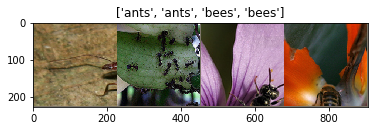

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""

    print("shape before transpose: ", inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))    # (channel, height, width) --> (height, width, channel)
    print("shape after transpose: ", inp.shape)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # reverse normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# load a batch
inputs, classes = next(iter(dataloaders['train']))

# put the images into the grid
out = torchvision.utils.make_grid(inputs)

# display the images with their class names as titles
imshow(out, title=[class_names[x] for x in classes])

## Transfer the knowledge from the reset18 model pretrained on ImageNet dataset

## Fine tuning ENABLED

In [0]:
# transfer feature extraction layers from ResNet18 trained on ImageNet dataset
model_ft = models.resnet18(pretrained=True) # get pretrained model

# freeze the feature extraction layer (uncomment the following two lines to freeze feature extraction layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features          # retrieve feature extraction layers of resnet18
                                            # model_ft.fc: the fully-connection layer of resnet18
                                            # model_ft.fc.in_features: input layer of model_ft.fc

model_ft.fc = nn.Linear(num_ftrs, 2)        # replace the fc layer to classify ants and bees

model_ft = model_ft.to(device)              # load the model on GPU

## Train the model on the target dataset

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#   see https://pytorch.org/docs/stable/optim.html for torch.optim.lr_scheduler.StepLR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림

                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  # torch.set_grad_enabled(True or False): enable or disable gradient calculation                
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6191 Acc: 0.6967
val Loss: 0.1809 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4970 Acc: 0.7787
val Loss: 0.3482 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.3521 Acc: 0.8525
val Loss: 0.2147 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3681 Acc: 0.8525
val Loss: 0.2939 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3479 Acc: 0.8730
val Loss: 0.3002 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4994 Acc: 0.7951
val Loss: 0.2595 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3219 Acc: 0.8566
val Loss: 0.1842 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.2628 Acc: 0.8893
val Loss: 0.1698 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2715 Acc: 0.8934
val Loss: 0.1735 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2326 Acc: 0.8852
val Loss: 0.1673 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2476 Acc: 0.9180
val Loss: 0.1665 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3607 Acc: 0.8402
val Loss: 0.1873 Acc: 0.9020

Epoch 12/24
----------
t

## Fine tuning DISABLED
Feature extraction layers are freezed!

In [0]:
model_ft = models.resnet18(pretrained=True)

# freeze the feature extraction layer (uncomment the following two lines to freeze feature extraction layers)
for param in model_ft.parameters():
   param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7941 Acc: 0.6311
val Loss: 0.3866 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.6044 Acc: 0.7459
val Loss: 0.1634 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4608 Acc: 0.7951
val Loss: 0.1952 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4501 Acc: 0.7828
val Loss: 0.3733 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3748 Acc: 0.8402
val Loss: 0.1982 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4510 Acc: 0.8033
val Loss: 0.1771 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4451 Acc: 0.8197
val Loss: 0.1836 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3900 Acc: 0.8361
val Loss: 0.1912 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2989 Acc: 0.8525
val Loss: 0.1769 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3227 Acc: 0.8607
val Loss: 0.1699 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3324 Acc: 0.8484
val Loss: 0.2005 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3316 Acc: 0.8443
val Loss: 0.1777 Acc: 0.9542

Epoch 12/24
----------
t

## Training from scratch
Feature extraction layers are randomly initialized

In [0]:
model_ft = models.resnet18(pretrained=False)

# freeze the feature extraction layer (uncomment the following two lines to freeze feature extraction layers)
# for param in model_ft.parameters():
#    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9117 Acc: 0.4959
val Loss: 0.6777 Acc: 0.5882

Epoch 1/24
----------
train Loss: 0.6998 Acc: 0.5984
val Loss: 0.8216 Acc: 0.5817

Epoch 2/24
----------
train Loss: 0.8106 Acc: 0.5656
val Loss: 0.8663 Acc: 0.5294

Epoch 3/24
----------
train Loss: 0.8024 Acc: 0.5492
val Loss: 0.8662 Acc: 0.5882

Epoch 4/24
----------
train Loss: 0.7411 Acc: 0.5902
val Loss: 0.8067 Acc: 0.5490

Epoch 5/24
----------
train Loss: 0.7500 Acc: 0.5492
val Loss: 0.6437 Acc: 0.5817

Epoch 6/24
----------
train Loss: 0.6118 Acc: 0.6762
val Loss: 0.5523 Acc: 0.7059

Epoch 7/24
----------
train Loss: 0.5974 Acc: 0.6639
val Loss: 0.5799 Acc: 0.6863

Epoch 8/24
----------
train Loss: 0.6229 Acc: 0.6352
val Loss: 0.6330 Acc: 0.6340

Epoch 9/24
----------
train Loss: 0.6041 Acc: 0.6721
val Loss: 0.6154 Acc: 0.6863

Epoch 10/24
----------
train Loss: 0.5759 Acc: 0.7049
val Loss: 0.5729 Acc: 0.6928

Epoch 11/24
----------
train Loss: 0.5709 Acc: 0.6967
val Loss: 0.5996 Acc: 0.6863

Epoch 12/24
----------
t